Import libraries

In [1]:
import seaborn as sn
import pandas as pd
import json, os
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import time
import random

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

from transformers import GPT2Tokenizer, TFGPT2Model
from transformers import set_seed

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Specify a constant seeder for processes

In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
set_seed(seed)

Pre-trained tokenizer

In [3]:
model_variation = "microsoft/CodeGPT-small-py"
PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "<|endoftext|>"

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained(model_variation, do_lower_case=True, pad_token=PAD_TOKEN,
    eos_token=EOS_TOKEN)
# gpt2 only NL
# microsoft/CodeGPT-small-py only PL
# microsoft/CodeGPT-small-py-adaptedGPT2 both NL and PL

In [5]:
# Define New tokens for string and numerical i.e., strId$ and numId$
new_tokens = ["strId$", "numId$"]
for new_token in new_tokens:
    if new_token not in tokenizer.get_vocab().keys():
        tokenizer.add_tokens(new_token)

In [6]:
def recall_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

def precision_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

def f1_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f1 = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f1

def f2_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f2 = 5*((prec*rec)/(4*prec+rec+K.epsilon()))
    return f2


In [7]:
def dropEmpty(tokens0):
    tokens = []
    for i in range(0, len(tokens0)):
        temp = tokens0[i]
        if temp != []:
            tokens.append(temp)
    return tokens

def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string 
    count = 0
    for ele in s: 
        if count==0:
            str1 = str1 + ele
        else:
            str1 = str1 + ' ' + ele
        count = count + 1
        #str1 += ele  
    
    # return string  
    return str1

def prepareData(data):
        
    # lowercase
    lines = []
    labels = []
    headlines = []
    for i in range(0, len(data)):
        labels.append(int(data[i][1]))
        headlines.append(data[i][0])
        line = data[i][2:]
        lows = [w.lower() for w in line]
        lines.append(lows)
    
    texts = []
    for i in range(0, len(lines)):
        texts.append(listToString(lines[i]))
    
    return texts, labels, headlines 

Read dataset

In [8]:
root_path = os.path.join('..', '..')
with open(os.path.join(root_path, 'data', 'dataset.csv'), newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = list(reader)
data = dropEmpty(data)

In [9]:
# Shuffle dataset
random.shuffle(data)
#data = data[0:100]

In [10]:
texts, labels, headlines = prepareData(data)

Explore data

Elements in dataset: 4184
2 categories found:
0
1


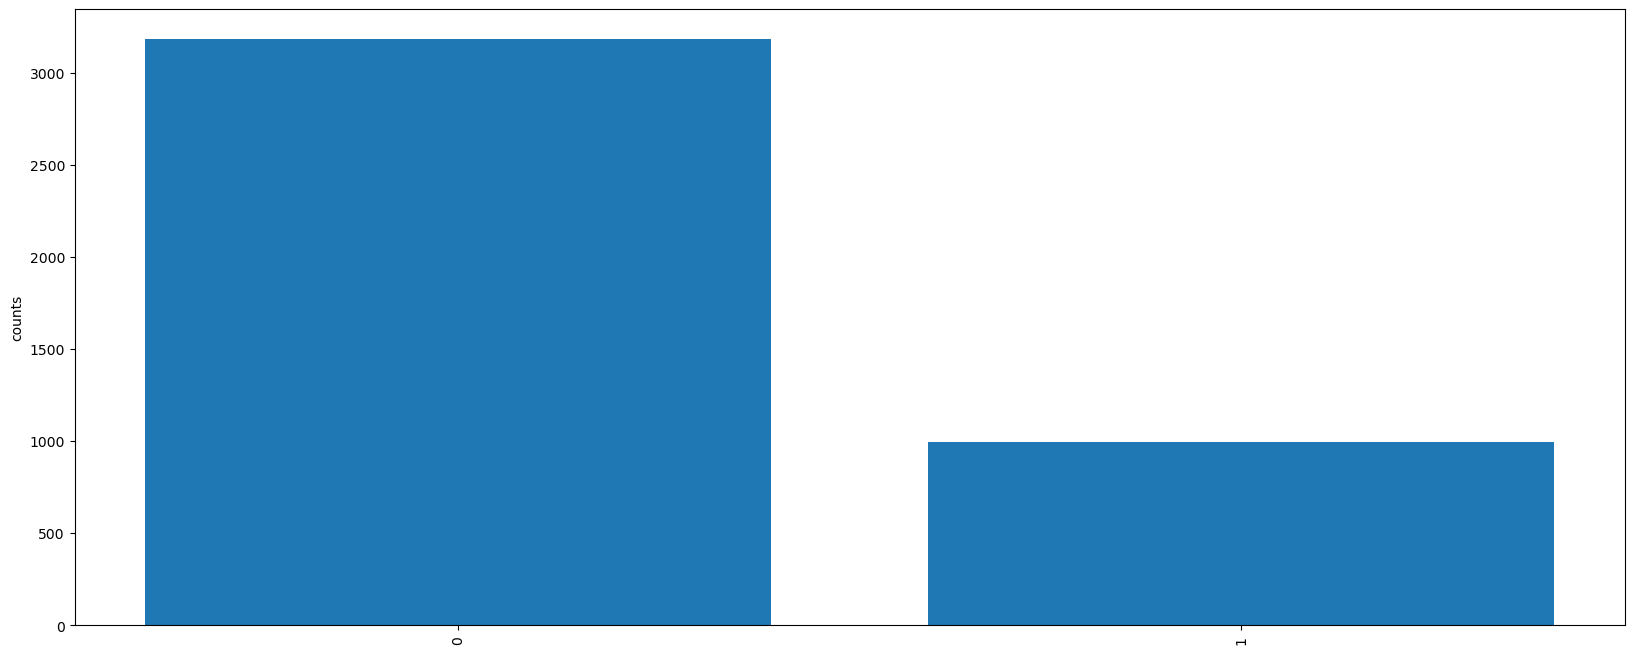

In [11]:
n_elements=len(headlines)
print('Elements in dataset:', n_elements)
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
print("{} categories found:".format(n_categories))
for category in categories:
    print(category)
    
fig=plt.figure(figsize=(20,8))
lbl, counts = np.unique(labels,return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center')
plt.xticks(ticks,lbl)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.show()

In [12]:
data = pd.DataFrame(({'Text': texts, 'Labels': labels}))

Split to train-val-test

In [13]:
val_ratio = 0.10

In [14]:
train_val_data, test_data = train_test_split(data, test_size=val_ratio, random_state=seed, stratify=data['Labels'])
train_data, val_data = train_test_split(train_val_data, test_size=val_ratio, random_state=seed, stratify=train_val_data['Labels'])
# print(len(data))
# print(len(train_val_data))
# print(len(test_data))
# print(len(train_data))
# print(len(val_data))
# print(len(val_data)+len(train_data)+len(test_data))
# print(len(val_data)+len(train_data))

Pre-trained model

In [15]:
model = TFGPT2Model.from_pretrained(model_variation,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id, num_labels=n_categories)

model.training = True

config = model.get_config()
print(config)

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at microsoft/CodeGPT-small-py.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


{'vocab_size': 50001, 'n_positions': 1024, 'n_embd': 768, 'n_layer': 12, 'n_head': 12, 'n_inner': None, 'activation_function': 'gelu_new', 'resid_pdrop': 0.1, 'embd_pdrop': 0.1, 'attn_pdrop': 0.1, 'layer_norm_epsilon': 1e-05, 'initializer_range': 0.02, 'summary_type': 'cls_index', 'summary_use_proj': True, 'summary_activation': None, 'summary_first_dropout': 0.1, 'summary_proj_to_labels': True, 'scale_attn_weights': True, 'use_cache': True, 'scale_attn_by_inverse_layer_idx': False, 'reorder_and_upcast_attn': False, 'bos_token_id': 0, 'eos_token_id': 50001, 'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': None, 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'chunk_size_feed_forward': 0, 'is_encoder_decoder': False, 'is_decoder': False, 'cross_attention_hidden_size': None, 'add_cross_attention': False, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_s

Resize model embedding to match new tokenizer

In [16]:
model.resize_token_embeddings(len(tokenizer))

Compute maximum length

In [17]:
def getMaxLen(X):

    # Code for identifying max length of the data samples after tokenization using transformer tokenizer
    
    max_length = 0
    # Iterate over each sample in your dataset
    for i, input_ids in enumerate(X):
        # Calculate the length of the tokenized sequence for the current sample
        length = tf.math.reduce_sum(tf.cast(input_ids != 1, tf.int32)).numpy()
        # Update max_length and max_row if the current length is greater
        if length > max_length:
            max_length = length
            max_row = i

    print("Max length of tokenized data:", max_length)
    print("Row with max length:", max_row)

    #X['input_ids'] = np.delete(X['input_ids'], max_row, axis=0)
    
    return max_length

In [18]:
X = [ex + EOS_TOKEN for ex in train_data['Text']]
X_ = [tokenizer(x, return_tensors='tf', max_length=512, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X]
X_in = tf.squeeze(tf.convert_to_tensor(X_), axis=1)
max_len = getMaxLen(X_in)

C:\Users\iliaskaloup\AppData\Roaming\Python\Python39\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Max length of tokenized data: 512
Row with max length: 0


Tokenization

In [19]:
X_train = [ex + EOS_TOKEN for ex in train_data['Text']]
X_train_ = [tokenizer(x, return_tensors='tf', max_length=max_len, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_train]
X_train_in = tf.squeeze(tf.convert_to_tensor(X_train_), axis=1)

X_val = [ex + EOS_TOKEN for ex in val_data['Text']]
X_val_ = [tokenizer(x, return_tensors='tf', max_length=max_len, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_val]
X_val_in = tf.squeeze(tf.convert_to_tensor(X_val_), axis=1)

X_test = [ex + EOS_TOKEN for ex in test_data['Text']]
X_test_ = [tokenizer(x, return_tensors='tf', max_length=max_len, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_test]
X_test_in = tf.squeeze(tf.convert_to_tensor(X_test_), axis=1)

In [20]:
X_train_mask_ = [tokenizer(x, return_tensors='tf', max_length=max_len, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_train]
X_train_mask = tf.squeeze(tf.convert_to_tensor(X_train_mask_), axis=1)

X_val_mask_ = [tokenizer(x, return_tensors='tf', max_length=max_len, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_val]
X_val_mask = tf.squeeze(tf.convert_to_tensor(X_val_mask_), axis=1)

X_test_mask_ = [tokenizer(x, return_tensors='tf', max_length=max_len, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_test]
X_test_mask = tf.squeeze(tf.convert_to_tensor(X_test_mask_), axis=1)

Set the GPT2 pre-trained layers

In [21]:
for layer in model.layers:
    layer.trainable = True

In [22]:
model.summary()

Model: "tfgpt2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124247040 
 r)                                                              
                                                                 
Total params: 124,247,040
Trainable params: 124,247,040
Non-trainable params: 0
_________________________________________________________________


Next we build on top of GPT2. The model takes in tokens and mask tensors. The outputs are the last hidden states of the last layer in the transformer. These are reduced using the mean over the sequence length, passed through 2 dense layers with dopout in between. The output layer has X nodes (softmax activation function for probabilities) for the X classes we want to predict.

In [23]:
input = tf.keras.layers.Input(shape=(None,), dtype='int32')
mask = tf.keras.layers.Input(shape=(None,), dtype='int32')
x = model(input, attention_mask=mask)
#x = x.last_hidden_state[:, -1]
x = tf.reduce_mean(x.last_hidden_state, axis=1)
x = tf.keras.layers.Dense(768, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

In [24]:
clf = tf.keras.Model([input, mask], output)
clf.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 tfgpt2_model (TFGPT2Model)     TFBaseModelOutputWi  124247040   ['input_1[0][0]',                
                                thPastAndCrossAtten               'input_2[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, None, 7                                           

Hyper-parameters

In [25]:
n_epochs = 6
batch_size = 6
lr = 2e-05 # 1e-5
patience = 5

In [26]:
optimizer = Adam(
    learning_rate=lr, # HF recommendation
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

loss = CategoricalCrossentropy(from_logits=True)

Build Model

In [27]:
clf.compile(
    optimizer=optimizer,
    loss=loss
)

Last thing we need to do is preparing the target tensor.

In [28]:
y_train_in = tf.constant(train_data['Labels'], dtype=tf.int32)
y_val_in = tf.constant(val_data['Labels'], dtype=tf.int32)
y_test_in = tf.constant(test_data['Labels'], dtype=tf.int32)

Train model

In [31]:
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience)
model_checkpoint = ModelCheckpoint('./checkpoints/best_weights', monitor='val_loss', mode='min', save_best_only=True)

history = clf.fit(
    x = {'input_1':X_train_in, 'input_2':X_train_mask},
    y = to_categorical(y_train_in),
    validation_data = ({'input_1':X_val_in, 'input_2':X_val_mask},
                        to_categorical(y_val_in)),
    epochs=n_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

milli_sec2 = int(round(time.time() * 1000))
print("Training is completed after", milli_sec2-milli_sec1)

Training...
Epoch 1/6


ResourceExhaustedError: Exception encountered when calling layer "attn" "                 f"(type TFAttention).

{{function_node __wrapped__Split_num_split_3_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[6,512,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Split] name: split

Call arguments received by layer "attn" "                 f"(type TFAttention):
  • x=tf.Tensor(shape=(6, 512, 768), dtype=float32)
  • layer_past=None
  • attention_mask=tf.Tensor(shape=(6, 1, 1, 512), dtype=float32)
  • head_mask=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • use_cache=True
  • output_attentions=False
  • training=True

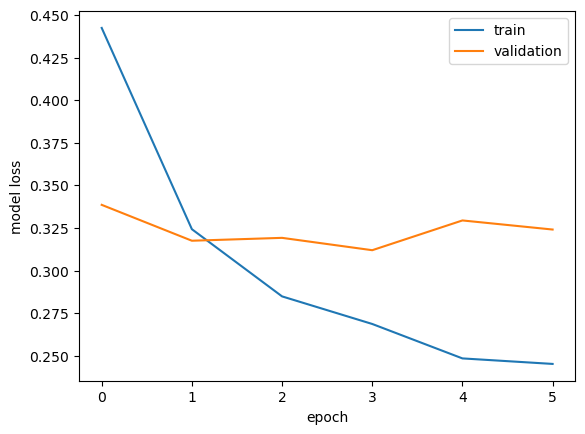

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
#plt.savefig('train_history.png')
plt.show()


Load best model from checkpoint during training with early stopping

In [46]:
clf.load_weights('./checkpoints/best_weights')

In [ ]:
clf.training = False

Classification report on validation data

In [26]:
print(classification_report(val_data['Labels'], np.argmax(clf.predict({'input_ids': X_val['input_ids'], 'attention_mask': X_val['attention_mask']}).logits, axis=1)))

 8/12 [===================>..........] - ETA: 1s

ResourceExhaustedError: Graph execution error:

Detected at node 'tfgpt2_for_sequence_classification/transformer/h_._9/attn/Softmax' defined at (most recent call last):
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\iliaskaloup\AppData\Local\Temp\ipykernel_10204\3519990862.py", line 1, in <module>
      print(classification_report(val_data['Labels'], np.argmax(model.predict({'input_ids': X_val['input_ids'], 'attention_mask': X_val['attention_mask']}).logits, axis=1)))
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\modeling_tf_utils.py", line 1050, in run_call_with_unpacked_inputs
      tf.convert_to_tensor([new_num_tokens, old_embedding_dim]),
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 1061, in call
      transformer_outputs = self.transformer(
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\modeling_tf_utils.py", line 1050, in run_call_with_unpacked_inputs
      tf.convert_to_tensor([new_num_tokens, old_embedding_dim]),
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 460, in call
      for i, (block, layer_past) in enumerate(zip(self.h, past_key_values)):
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 464, in call
      outputs = block(
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 252, in call
      output_attn = self.attn(
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 195, in call
      attn_outputs = self._attn(query, key, value, attention_mask, head_mask, output_attentions, training=training)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 130, in _attn
      w = stable_softmax(w, axis=-1)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\tf_utils.py", line 70, in stable_softmax
      return tf.nn.softmax(logits=logits + 1e-9, axis=axis, name=name)
Node: 'tfgpt2_for_sequence_classification/transformer/h_._9/attn/Softmax'
OOM when allocating tensor with shape[32,12,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node tfgpt2_for_sequence_classification/transformer/h_._9/attn/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_197317]

Make predictions on the testing set and compute evaluation metrics

In [51]:
predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}).logits
y_predicted = np.argmax(predicted, axis=1)

targets = test_data['Labels']
print(classification_report(targets, y_predicted))

168/419 [===========>..................] - ETA: 3:14

InvalidArgumentError: Graph execution error:

Detected at node 'tfgpt2_for_sequence_classification_1/GatherV2' defined at (most recent call last):
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\iliaskaloup\AppData\Local\Temp\ipykernel_12628\3919007435.py", line 1, in <module>
      predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, batch_size=1).logits
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\modeling_tf_utils.py", line 1050, in run_call_with_unpacked_inputs
      tf.convert_to_tensor([new_num_tokens, old_embedding_dim]),
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 1080, in call
      if self.config.pad_token_id is None:
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 1083, in call
      if input_ids is not None:
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 1095, in call
      in_logits = tf.gather(logits, sequence_lengths, batch_dims=1, axis=1)
Node: 'tfgpt2_for_sequence_classification_1/GatherV2'
Detected at node 'tfgpt2_for_sequence_classification_1/GatherV2' defined at (most recent call last):
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\iliaskaloup\AppData\Local\Temp\ipykernel_12628\3919007435.py", line 1, in <module>
      predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, batch_size=1).logits
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\modeling_tf_utils.py", line 1050, in run_call_with_unpacked_inputs
      tf.convert_to_tensor([new_num_tokens, old_embedding_dim]),
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 1080, in call
      if self.config.pad_token_id is None:
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 1083, in call
      if input_ids is not None:
    File "C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 1095, in call
      in_logits = tf.gather(logits, sequence_lengths, batch_dims=1, axis=1)
Node: 'tfgpt2_for_sequence_classification_1/GatherV2'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  indices[0] = -1 is not in [0, 512)
	 [[{{node tfgpt2_for_sequence_classification_1/GatherV2}}]]
	 [[tfgpt2_for_sequence_classification_1/GatherV2/_305]]
  (1) INVALID_ARGUMENT:  indices[0] = -1 is not in [0, 512)
	 [[{{node tfgpt2_for_sequence_classification_1/GatherV2}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_106146]

In [ ]:
accuracy=accuracy_score(targets, y_predicted)
precision=precision_score(targets, y_predicted)
recall=recall_score(targets, y_predicted)
roc_auc=roc_auc_score(targets, y_predicted)
f1=f1_score(targets, y_predicted)
f2 = (5*precision*recall) / (4*precision+recall)

conf_matrix = confusion_matrix(targets, y_predicted)
sn.heatmap(conf_matrix, annot=True)

tn, fp, fn, tp = conf_matrix.ravel()
acc = ((tp+tn)/(tp+tn+fp+fn))
print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)

print("Accuracy:%.2f%%"%(accuracy*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("Roc_Auc score:%.2f%%"%(roc_auc*100))
print("F1 score:%.2f%%"%(f1*100))
print("F2 score:%.2f%%"%(f2*100))